# Training tree-based models for time series forecasting

After working with the ARIMA model yesterday, today you will use the same data to fit a Random Forest (RF) and XGBoost model on it.

Throughout the seminar, we will use the following splits for training, validation, and testing. Make sure to keep the tests unseen until the final evaluation (information leakage):

- Training set: 2009-2013
- Validation set: 2014
- Test set: 2015-2016

Required python packages: pandas, numpy, matplotlib, scikit-learn, xgboost

## Task 1: Feature Engineering

For random forest and xgboost, engineer features for the flu-trends dataset by incorporating lagged values (e.g., 8 weeks); ensure that your feature engineering process does not introduce information from future data points into past records.

> For instance, use the past 8 weeks to predict the next week.X-columns: FluVisits_t-8, FluVisits_t-7, ..., FluVisits_t-1
>
> You can also predict more than one week ahead. Then you need to shift the next samples accordingly.X-columns: FluVisits_t-8, FluVisits_t-7, ..., FluVisits_t-1
Y-columns: FluVisits_t, FluVisits_t+1, FluVisits_t+2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV



In [2]:
test = pd.read_csv(os.path.join('..', 'data', 'interim', 'test.csv'))
train = pd.read_csv(os.path.join('..', 'data', 'interim', 'training.csv'))
val = pd.read_csv(os.path.join('..', 'data', 'interim', 'validation.csv'))

In [3]:
print(test.shape)
print(train.shape)
print(val.shape)

(78, 132)
(236, 132)
(52, 132)


```python
 def create_features(data: pd.DataFrame, target_column: str, feature_length: int = 8, prediction_length: int = 2) -> [np.ndarray, np.ndarray]:
    ...
    return X, y
```

In [4]:
def create_features(data: pd.DataFrame, target_column: str, feature_length: int = 8, prediction_length: int = 2) -> tuple[np.ndarray, np.ndarray]:
    """
    Create features and target arrays for time series forecasting.

    Args:
        data (pd.DataFrame): The input data containing the time series.
        target_column (str): The name of the target column to predict.
        feature_length (int, optional): The number of past observations to use as features. Defaults to 8.
        prediction_length (int, optional): The number of future observations to predict. Defaults to 2.

    Returns:
        tuple[np.ndarray, np.ndarray]: The feature and target arrays.
    """
    
    target_data = data[target_column].values
    for i in range(feature_length, len(data) - prediction_length + 1): # Iterate over rows from e.g. 8 to len(data)-2
        features = target_data[i-feature_length:i] # Get the last 8 values as features as np array
        target = target_data[i:i+prediction_length] # Get the next 2 values as target as np array
        # for first iteration, initialize X and y
        if i == feature_length:
            X = np.array([features])
            y = np.array(target)
        else: # Add new rows to ndarrays
            X = np.vstack([X, features])
            y = np.vstack([y, target])
    return X, y

In [5]:
X_train, y_train = create_features(train, target_column="FluVisits", prediction_length=2, feature_length=8)
X_train.shape, y_train.shape

((227, 8), (227, 2))

## Task 2: Fitting the models

Task 2.1: Fit a Random Forest model to the data. Evaluate the model using the test set.

In [6]:
#training
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)

X_test, y_test = create_features(test, target_column="FluVisits", prediction_length=2, feature_length=8)
y_predictions = rf.predict(X_test)
print(y_predictions.shape)

(69, 2)


In [7]:
#evaluation:
score = rf.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, y_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, y_predictions)
print(f"MSE: {mse}, MAPE: {mape}", f"R^2: {score}")

MSE: 41498.65905579709, MAPE: 0.22698652534581096 R^2: 0.6719457908495874


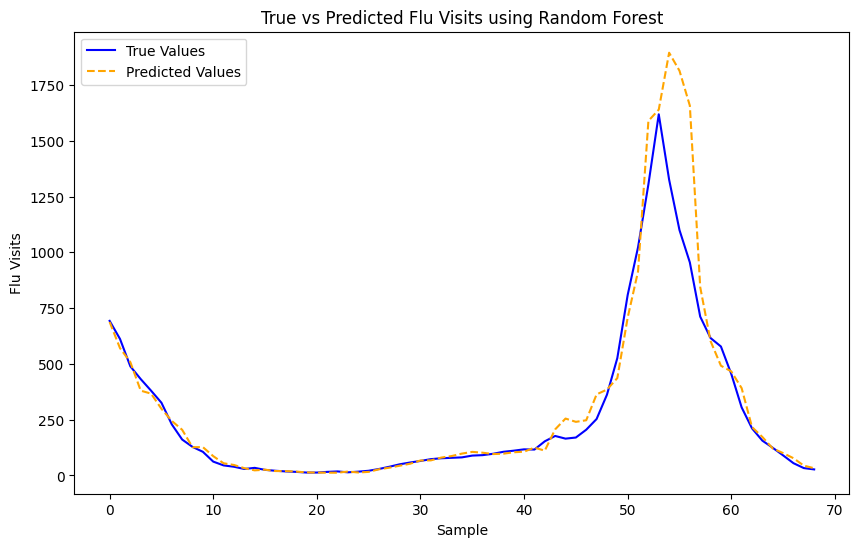

In [8]:
# visualization

plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values', color='blue')
plt.plot(y_predictions[:, 0], label='Predicted Values', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Flu Visits')
plt.title('True vs Predicted Flu Visits using Random Forest')
plt.show()

Task 2.2: Fit a XGBoost model to the data. Evaluate the model using the test set.

In [9]:
xgb_reg = xgb.XGBRegressor(randompip_state=42)
xgb_reg.fit(X_train, y_train)
xgb_prediction = xgb_reg.predict(X_test)

c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:36:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "randompip_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
#evaluation:
R2 = xgb_reg.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, xgb_prediction)
mape = metrics.mean_absolute_percentage_error(y_test, xgb_prediction)
print(f"R2: {R2}, MSE: {mse}, MAPE: {mape}")


R2: 0.5997294187545776, MSE: 50538.58203125, MAPE: 0.25446754693984985


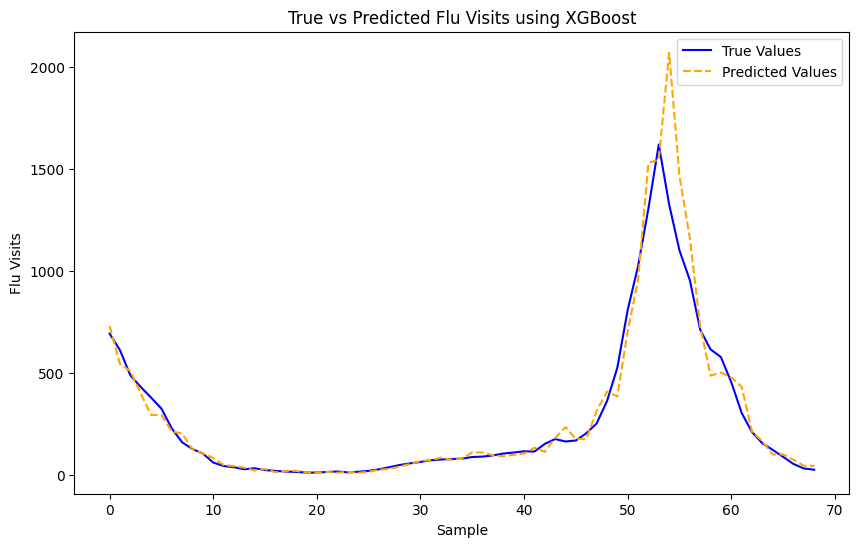

In [11]:
# visualization

plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values', color='blue')
plt.plot(xgb_prediction[:, 0], label='Predicted Values', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Flu Visits')
plt.title('True vs Predicted Flu Visits using XGBoost')
plt.show()

Describe the performance of the models and compare them in a few sentences. How do they perform in comparison to each other?

## Task 3: Hyperparameter tuning via grid search

Tune the hyperparameters of the Random Forest and XGBoost models using grid search. Focus on the following hyperparameters:

Random Forest:
- n_estimators
- max_depth
- ...

XGBoost:
- gamma
- max_depth
- eta
- ...

Optimize the hyperparameters using the validation set and the refit the models using the best hyperparameters on the entire training set and evaluate them on the test set.

In [12]:
# start with random forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

xgboost_param_grid = {
    'gamma': [0, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.2]
}


X_val, y_val = create_features(val, target_column="FluVisits", prediction_length=2, feature_length=8)


In [13]:
def grid_search(model, params: dict) -> tuple[dict[any, any] | None, float]:
    """A function that performs grid search over a given parameter grid for a specified model.
       It uses the training set to create a new model and tests it on the validation set. The metric used is the R^2 score.

    Args:
        model (estimator Object): _description_
        params (dict): A dictionary where keys are parameter names and values are the lists of values to try.

    Returns:
        _type_: _description_
    """
    keys, values = zip(*params.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    best_score = -np.inf
    best_param = None
    for param in permutations_dicts:

        new_model = model(random_state=42, **param)
        new_model.fit(X_train, y_train)
        R2_score = new_model.score(X_val, y_val)
        #print(f"R^2 score: {R2_score}")
        if R2_score > best_score:
            best_score = R2_score
            best_param = param
    return best_param, best_score

In [14]:
best_param_rf, best_score_rf = grid_search(RandomForestRegressor, rf_param_grid)
print(f"Best params: {best_param_rf}, Best R^2 score: {best_score_rf}")

Best params: {'n_estimators': 100, 'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'min_samples_leaf': 1}, Best R^2 score: 0.8315733372685314


In [15]:
best_param_xgb, best_score_xgb = grid_search(xgb.XGBRegressor, xgboost_param_grid)
print(f"Best params: {best_param_xgb}, Best R^2 score: {best_score_xgb}")

Best params: {'gamma': 0, 'max_depth': 3, 'eta': 0.2}, Best R^2 score: 0.8651692867279053


In [ ]:
# fitting the Models with the best parameters:

rf_optimal = RandomForestRegressor(random_state=42, **best_param_rf)
rf_optimal.fit(X_train, y_train)

rf_opt_predictions = rf_optimal.predict(X_test)


xgb_optimal = xgb.XGBRegressor(random_state=42, **best_param_xgb)
xgb_optimal.fit(X_train, y_train)

xgb_opt_predictions = xgb_optimal.predict(X_test)

In [17]:
# evaluating the models with optimal parameters:

score = rf_optimal.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, rf_opt_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, rf_opt_predictions)
print(f" Random Forest optimized: MSE: {mse}, MAPE: {mape}", f"R^2: {score}")


score = xgb_optimal.score(X_test, y_test)
mse = metrics.mean_squared_error(y_test, xgb_opt_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, xgb_opt_predictions)
print(f" XGBoost optimized: MSE: {mse}, MAPE: {mape}", f"R^2: {score}")

 Random Forest optimized: MSE: 42163.30027869396, MAPE: 0.22766694892496742 R^2: 0.6666586674841464
 XGBoost optimized: MSE: 37654.203125, MAPE: 0.22494453191757202 R^2: 0.7017157077789307


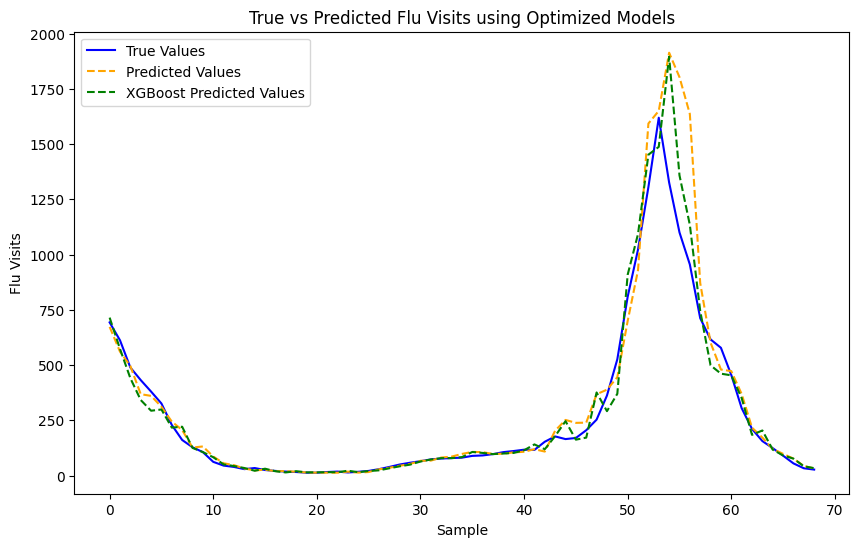

In [18]:
# visualization of the optimized models

plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values', color='blue')
plt.plot(rf_opt_predictions[:, 0], label='Predicted Values', color='orange', linestyle='--')
plt.plot(xgb_opt_predictions[:, 0], label='XGBoost Predicted Values', color='green', linestyle='--')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Flu Visits')
plt.title('True vs Predicted Flu Visits using Optimized Models')
plt.show()

Using Grid Search to find more optimal parameters for both models did not lead to a better performance for the Random Forest model. The lowest R2 score we could achieve was 0.667, while the MSE was 42163.3 and the MAPE was 0.227. This suggests, that using the default parameters was already a good choice for this dataset, or that the grid parameters we selected just did not include a better fitting combination.
For the XGBoost model, we reached values of MSE: 37654.2, MAPE: 0.225 R^2: 0.702, which is a slight improvement on all metrics compared to the values R2: 0.600, MSE: 50538.6, MAPE: 
0.254.



## Task 4: Time series cross-validation

Implement a time series cross-validation strategy to optimize the hyperparameters of the models. Except for the cross-validation strategy, the procedure is the same as in Task 3. You only need to define different training and validation sets before performing the grid search. In the end, you take the parameters that performed best across all folds and refit the models on the entire training set and evaluate them on the test set.

In [19]:
# sklearn time series split function will do the split for us?
tscv = TimeSeriesSplit()

## Combine Test and Validation data

In [20]:
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.vstack([y_train, y_val])

## Random Forest with Time Series Cross -Validation

In [21]:
rf_cv = RandomForestRegressor(random_state=42)

In [22]:
rf_model = GridSearchCV(estimator=rf_cv, param_grid=rf_param_grid, scoring='r2', cv=tscv, n_jobs=-1)
rf_model.fit(X_train_val, y_train_val)
y_pred = rf_model.predict(X_test)
R2_score = rf_model.score(X_test, y_test)


In [23]:
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'R2: {R2_score}, Mape: {mape}, MSE: {mse}')

R2: 0.6825462689612135, Mape: 0.22116688261240897, MSE: 40163.394137150455


In [24]:
rf_model.best_params_, rf_model.best_score_

({'max_depth': None,
  'max_features': None,
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100},
 0.8384984883781677)

## XGBoost with Time Series CV

In [25]:
xgb_cv = xgb.XGBRegressor(random_state=42)
xgb_model = GridSearchCV(estimator=xgb_cv, param_grid=rf_param_grid, scoring='r2', cv=tscv, n_jobs=-1)
xgb_model.fit(X_train_val, y_train_val)
y_pred = xgb_model.predict(X_test)

c:\Users\samue\Documents\Dateien\Life Science Informatics\Machine learning hands on\ML-handson\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:40:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
R2_score = xgb_model.score(X_test, y_test)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'R2: {R2_score}, MAPE: {mape}, MSE: {mse}')

R2: 0.7286827564239502, MAPE: 0.23964154720306396, MSE: 34279.2109375


In [27]:
xgb_model.best_params_, xgb_model.best_score_

({'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.7893886685371398)

Using Time series cross validation leads to a more robust set of parameters for both Models.
For the Random Forest, we were able to increase the R2 score from 0.67 to 0.73, while MSE was reduced from 41498.7 to 34279.2, only the mape got slightly worse from 0.23 to 0.24 compared to the model that used no hyperparameter tuning (default values).

For the XGBoost model we reduced the MSE from 50538.6 to 34279.2, increased the R2 score from 0.600 to 0.729 while MAPE also reduced from 0.254 to 0.240 compared to the model with all default values. 



# Optional Task:
- Take a look which other features could be good predictors for the flu visits. How does including additional features impact the overall model performance?